In [1]:
from __future__ import unicode_literals, print_function, division
import numpy as np
import pandas as pd
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preprocessing


In [3]:
!unzip /content/drive/MyDrive/archive.zip

Archive:  /content/drive/MyDrive/archive.zip
  inflating: Reddit_comments.db      


In [4]:
import sqlite3
con = sqlite3.connect('/content/Reddit_comments.db')
from pandas import read_sql_query, read_sql_table

with sqlite3.connect('/content/Reddit_comments.db') as dbcon:
    tables = list(read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", dbcon)['name'])
    out = {tbl : read_sql_query(f"SELECT * from {tbl}", dbcon) for tbl in tables}
out = out['rc']
out.dropna(inplace=True)

In [5]:
out

,parent_id,comment_id,pcomment,comment,score,subreddit
2,t1_cnbkf1f,t1_cnbn4j0,"Yeah, probably.","If she can't say yes on the spot, I'd legit re...",11,AskMen
5,t1_cnbkla9,t1_cnbn4j6,"I legitimately have no idea what's going on, b...",Me neither,3,twitchplayspokemon
7,t1_cnblwj8,t1_cnbn4jc,And sorta not really even a doctor.,He was a great Dr. Just not for humans.,4,WTF
8,t1_cnbhvpr,t1_cnbn4jj,"So, fat dudes and feminists wanted to circleje...",That's offensive to any normal fat guy.,9,TumblrInAction
10,t1_cnbmy2p,t1_cnbn4js,"If that epiphany ever comes, we probably won't...",We'll see a lack of rants.,9,anime
...,...,...,...,...,...,...
6839867,t1_co773fp,t1_co77fz1,Looks like he gives a cite.,"Thanks, so it's from the book 'A man on the mo...",6,Frisson
6839875,t1_co6zor8,t1_co77g1f,Can you somehow share this? I really like it a...,Hopefully this will work. Here's the rmskin h...,11,Rainmeter
6839877,t1_co7788g,t1_co77g1l,1644 robot that would be,1645 very helpful in preforming,3,counting
6839881,t1_co777b0,t1_co77g2p,The store on the left is Cards Against Humanit...,Also they have your shipping address if you're...,72,pcmasterrace


In [6]:
out = out[['pcomment', 'comment']].reset_index(drop=True)
out

,pcomment,comment
0,"Yeah, probably.","If she can't say yes on the spot, I'd legit re..."
1,"I legitimately have no idea what's going on, b...",Me neither
2,And sorta not really even a doctor.,He was a great Dr. Just not for humans.
3,"So, fat dudes and feminists wanted to circleje...",That's offensive to any normal fat guy.
4,"If that epiphany ever comes, we probably won't...",We'll see a lack of rants.
...,...,...
2024264,Looks like he gives a cite.,"Thanks, so it's from the book 'A man on the mo..."
2024265,Can you somehow share this? I really like it a...,Hopefully this will work. Here's the rmskin h...
2024266,1644 robot that would be,1645 very helpful in preforming
2024267,The store on the left is Cards Against Humanit...,Also they have your shipping address if you're...


In [7]:
SOS_token = 0
EOS_token = 1
#BOS asdsad EOS

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def __repr__(self):
        most_popular_words = sorted(
            self.word2count.keys(), key=lambda word: self.word2count[word], reverse=True
        )[:10]
        most_popular_words = ", ".join(most_popular_words)
        return f"Language: {self.name} | Num words: {self.n_words} | Most popular: {most_popular_words}"

def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
!pip install transformers
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 58.2 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [9]:
MAX_LENGTH = 30

def filterPair(p):
    return len(p.split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def readLangs(lang1, lang2, df, reverse=False):
    print("Reading lines...")
    pairs = df.values
    pairs = [[normalizeString(s) for s in l] for l in pairs]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def prepareData(lang1, lang2, df, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, df, reverse)
    print("Read %s sentence pairs" % len(pairs))
    filter = np.vectorize(filterPair)
    pairs = [pair for pair in pairs if filter(pair).all()] 
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('pcomment', 'comment', out)
print(random.choice(pairs))

Reading lines...
Read 2024269 sentence pairs
Trimmed to 1370389 sentence pairs
Counting words...
Counted words:
pcomment 286703
comment 278833
['delaware national champs !', ' blue hens ! ']


In [10]:
input_lang

Language: pcomment | Num words: 286703 | Most popular: ., the, i, a, to, ?, , it, you, that

In [11]:
output_lang

Language: comment | Num words: 278833 | Most popular: ., the, i, a, , it, to, you, that, s

# Modeling


In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, weight):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedder = nn.Embedding.from_pretrained(weight) # nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embeddings = self.embedder(input).view(1, 1, -1)
        output, hidden = self.gru(embeddings, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(
                torch.cat((embedded[0], hidden[0]), 1)
            ), 
            dim=1
        )
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0)
        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Куча функций из ноутбука...

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

teacher_forcing_ratio = 0.5


def train(
    input_tensor, 
    target_tensor,
    encoder, 
    decoder, 
    encoder_optimizer,
    decoder_optimizer, 
    criterion,
    max_length=MAX_LENGTH
):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # y_true: [sos, i, love, pizza, eos]
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # [0.9, 0.1, 0.0]
            # [1, 0, 0]
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # beam_search is betters
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                # y_true: [sos, i, eos]
                # [sos, i, eos, love]
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


# Train

In [ ]:
import gensim
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
weights = torch.FloatTensor(model.vectors)

In [ ]:
weights.size()

torch.Size([400000, 50])

In [ ]:
hidden_size = 50

encoder1 = EncoderRNN(hidden_size, weights).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=50)

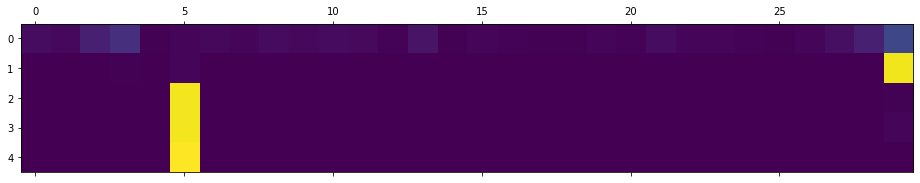

In [ ]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "hello everyone .")
plt.matshow(attentions.numpy())
plt.show()

input = i sometimes ask myself if it is possible not to miss the deadline .
output = i i . i . . <EOS>


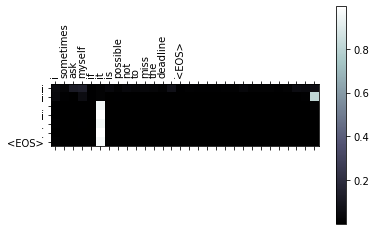

input = it is so funny yep .
output = i . . . . <EOS>


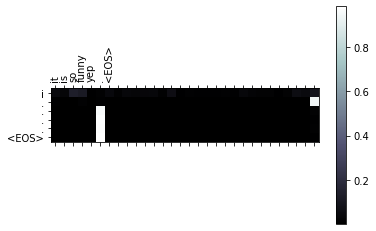

input = in my cycle the entire development team would have been shot by the ship s main batteries after they had been thrown out the airlock
output = i i i . . . i <EOS>


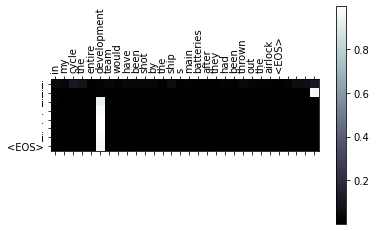

input = just stay away from my house .
output = i . . . . <EOS>


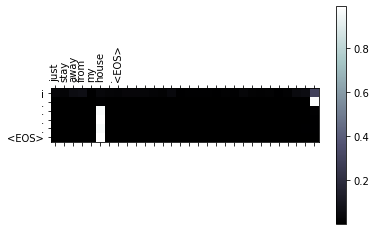

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("i sometimes ask myself if it is possible not to miss the deadline .")

evaluateAndShowAttention("it is so funny yep .")


evaluateAndShowAttention('in my cycle the entire development team would have been shot by the ship s main batteries after they had been thrown out the airlock')

evaluateAndShowAttention("just stay away from my house .")

OK пробую без предобученной модели

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embeddings = self.embedder(input).view(1, 1, -1)
        output, hidden = self.gru(embeddings, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


hidden_size = 256

encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder2, attn_decoder2, 75000, print_every=100)

0m 22s (- 278m 20s) (100 0%) 6.4046
0m 41s (- 259m 19s) (200 0%) 6.8664
1m 2s (- 261m 14s) (300 0%) 6.9382
1m 25s (- 265m 1s) (400 0%) 6.3931
1m 44s (- 258m 33s) (500 0%) 5.9451
2m 4s (- 256m 38s) (600 0%) 5.5561
2m 22s (- 252m 48s) (700 0%) 5.4646
2m 42s (- 250m 53s) (800 1%) 6.1140
3m 4s (- 253m 39s) (900 1%) 6.1499
3m 22s (- 249m 49s) (1000 1%) 5.1575
3m 44s (- 250m 50s) (1100 1%) 6.2851
4m 5s (- 251m 42s) (1200 1%) 6.3738
4m 26s (- 252m 5s) (1300 1%) 5.8216
4m 47s (- 251m 36s) (1400 1%) 5.5428
5m 8s (- 251m 43s) (1500 2%) 5.5415
5m 28s (- 250m 56s) (1600 2%) 5.7776
5m 50s (- 251m 34s) (1700 2%) 5.8310
6m 10s (- 251m 12s) (1800 2%) 5.3040
6m 30s (- 250m 18s) (1900 2%) 5.3879
6m 49s (- 249m 21s) (2000 2%) 5.9305
7m 10s (- 249m 2s) (2100 2%) 5.8352
7m 30s (- 248m 41s) (2200 2%) 5.6468
7m 50s (- 248m 1s) (2300 3%) 5.0684
8m 12s (- 248m 4s) (2400 3%) 5.5335
8m 34s (- 248m 36s) (2500 3%) 5.7367
8m 54s (- 247m 57s) (2600 3%) 5.7588
9m 16s (- 248m 33s) (2700 3%) 5.9865
9m 39s (- 248m 59s) 

KeyboardInterrupt: ignored

In [44]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder2, attn_decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("i sometimes ask myself if it is possible not to miss the deadline .")

evaluateAndShowAttention("it is so funny yep .")


evaluateAndShowAttention('in my cycle the entire development team would have been shot by the ship s main batteries after they had been thrown out the airlock .')

evaluateAndShowAttention("just stay away from my house .")

input = i sometimes ask myself if it is possible not to miss the deadline .
output = i is . . . . <EOS>
input = it is so funny yep .
output = it is a . . . . . <EOS>
input = in my cycle the entire development team would have been shot by the ship s main batteries after they had been thrown out the airlock .
output = i . the . . . <EOS>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


input = just stay away from my house .
output =  i . . <EOS>


In [21]:
evaluateAndShowAttention('looks like he gives a cite .')

input = looks like he gives a cite .
output = he would be a lot . <EOS>


In [50]:
evaluateAndShowAttention('delaware national champs !')

input = delaware national champs !
output =  i . <EOS>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


я так и не понял, что не так (